In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

#import AAPL csv, csv data is different from yahoo finance
csv_AAPL = pd.read_csv('../../data/individual_tickers/AAPL_historic.csv')

#since date type is just a object convert it to a datetime object
csv_AAPL['Date'] = pd.to_datetime(csv_AAPL['Date'])

#declare the features
features = ['Close','High','Low','Open','Volume']

#declare the type of scalar you're using
scaler = StandardScaler()
csv_AAPL[features] = scaler.fit_transform(csv_AAPL[features])

#drop unneeded values and then create a new csv
# drops Date (or any other non‑numeric columns) if you haven’t already
df_model = csv_AAPL.drop(columns=['Date'])

# save
df_model.to_csv('../../data/individual_tickers/scaled_data.csv', index=False)
print("Saved cleaned & scaled data to scaled_data.csv")

Saved cleaned & scaled data to scaled_data.csv


Iteration 1, loss = 0.45431411
Iteration 2, loss = 0.21578311
Iteration 3, loss = 0.07688085
Iteration 4, loss = 0.02189001
Iteration 5, loss = 0.00881596
Iteration 6, loss = 0.00529322
Iteration 7, loss = 0.00622610
Iteration 8, loss = 0.00257499
Iteration 9, loss = 0.00175718
Iteration 10, loss = 0.00160283
Iteration 11, loss = 0.00135168
Iteration 12, loss = 0.00102181
Iteration 13, loss = 0.00095480
Iteration 14, loss = 0.00085780
Iteration 15, loss = 0.00079266
Iteration 16, loss = 0.00074394
Iteration 17, loss = 0.00070200
Iteration 18, loss = 0.00065639
Iteration 19, loss = 0.00062609
Iteration 20, loss = 0.00060104
Iteration 21, loss = 0.00055966
Iteration 22, loss = 0.00052002
Iteration 23, loss = 0.00051642
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Test MSE: 0.0055
Test R²:  0.9625


<Axes: >

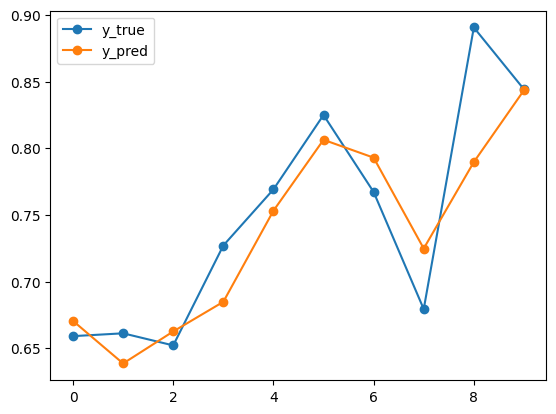

In [3]:
#This cell is for ur model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

#prep features and drop unneeded data
X = df_model.drop(columns=['Close'])
y = df_model['Close']

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.1, shuffle=False,random_state=42)

#instantiate and fit MLP
mlp_model = MLPRegressor(hidden_layer_sizes=(64,64),activation='relu',solver='adam',
                         learning_rate_init=1e-3,max_iter=200,random_state=42,verbose=True)

mlp_model.fit(X_train,y_train)
#remember convergence shows that when model reaches stable state it doesnt improve

#evaluate the model
y_pred = mlp_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²:  {r2:.4f}")

#predictions vs actual
pd.DataFrame({
    'y_true': y_test.values[:10],
    'y_pred': y_pred[:10],
}).plot(marker='o')


Iteration 1, loss = 0.15718423
Iteration 2, loss = 0.01370707
Iteration 3, loss = 0.00683216
Iteration 4, loss = 0.00326967
Iteration 5, loss = 0.00215524
Iteration 6, loss = 0.00124501
Iteration 7, loss = 0.00087666
Iteration 8, loss = 0.00086018
Iteration 9, loss = 0.00104384
Iteration 10, loss = 0.00063397
Iteration 11, loss = 0.00055881
Iteration 12, loss = 0.00087009
Iteration 13, loss = 0.00145702
Iteration 14, loss = 0.00111582
Iteration 15, loss = 0.00071602
Iteration 16, loss = 0.00066462
Iteration 17, loss = 0.00053257
Iteration 18, loss = 0.00050420
Iteration 19, loss = 0.00058066
Iteration 20, loss = 0.00056167
Iteration 21, loss = 0.00048024
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Test MSE: 0.0013
Test R²:  0.9910


<Axes: >

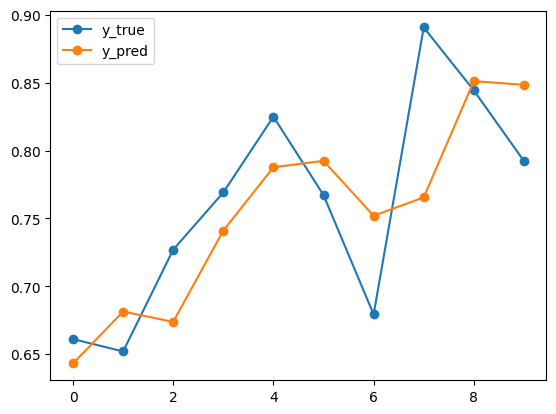

In [47]:
#=== Feature engineering + model training cell ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Start from your cleaned & scaled df_model (must include 'Date' & 'Close')
df_fe = csv_AAPL.copy()

# 2) Add lag and rolling‑window features (all shifted by 1 day)
df_fe['Close_lag1']     = df_fe['Close'].shift(1)
df_fe['MA_5']           = df_fe['Close'].rolling(window=5).mean().shift(1)
df_fe['Volatility_5']   = df_fe['Close'].rolling(window=5).std().shift(1)

# 3) Encode weekday cyclically
df_fe['Weekday']        = df_fe['Date'].dt.weekday
df_fe['Weekday_sin']    = np.sin(2 * np.pi * df_fe['Weekday'] / 7)
df_fe['Weekday_cos']    = np.cos(2 * np.pi * df_fe['Weekday'] / 7)

# 4) Drop rows with NaNs (first few days lack history)
df_fe.dropna(inplace=True)

# 5) Prepare X and y
X = df_fe.drop(columns=['Date','Close'])
y = df_fe['Close']

# 6) Train/test split (80/20 chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# 7) Instantiate and fit your MLP
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128,128),
    alpha=1e-4,
    activation='relu',
    solver='adam',
    learning_rate_init=0.01,
    max_iter=200,
    random_state=42,
    verbose=True
)
mlp_model.fit(X_train, y_train)

# 8) Evaluate
y_pred = mlp_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²:  {r2:.4f}")

# 9) Quick plot of first 10 true vs. predicted
pd.DataFrame({
    'y_true': y_test.values[:10],
    'y_pred': y_pred[:10],
}).plot(marker='o')


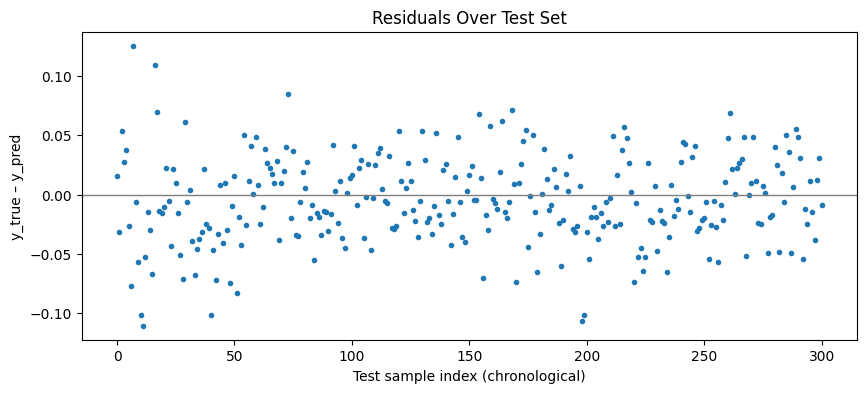

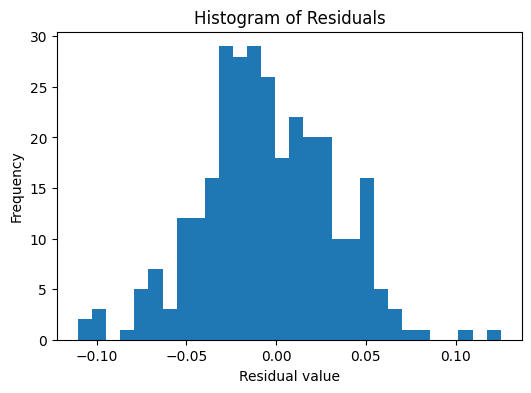

In [45]:
import matplotlib.pyplot as plt

# 1.1 Compute residuals
y_pred = mlp_model.predict(X_test)
residuals = y_test - y_pred

# 1.2 Plot residuals over time (chronologically)
plt.figure(figsize=(10,4))
plt.plot(residuals.values, marker='.', linestyle='none')
plt.axhline(0, color='gray', linewidth=1)
plt.title("Residuals Over Test Set")
plt.xlabel("Test sample index (chronological)")
plt.ylabel("y_true – y_pred")
plt.show()

# 1.3 Plot residual histogram
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.show()


In [38]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor

# Time-series-aware split
tscv = TimeSeriesSplit(n_splits=5)

# Define full search space
param_grid = {
    'hidden_layer_sizes': [
        (64,),              # shallow
        (128,),             # medium
        (128, 64),          # 2 layers
        (128, 128),         # 2 deeper
        (128, 128, 64),     # your current
        (256, 128, 64)      # even deeper
    ],
    'learning_rate_init': [1e-2, 5e-3, 1e-3, 5e-4],
    'alpha': [0, 1e-5, 1e-4, 1e-3]
}

# Wrap the regressor in GridSearchCV
grid = GridSearchCV(
    estimator=MLPRegressor(
        activation='relu',
        solver='adam',
        max_iter=200,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1  # parallelize search if possible
)

# Fit the grid search
grid.fit(X_train, y_train)

# Output best model info
print("✅ Best Parameters:", grid.best_params_)
print("📉 Best CV MSE:", -grid.best_score_)

# Optional: Save best model
# import joblib
# joblib.dump(grid.best_estimator_, 'best_mlp_model.pkl')



Fitting 5 folds for each of 96 candidates, totalling 480 fits
✅ Best Parameters: {'alpha': 0, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}
📉 Best CV MSE: 0.008254437128634332
